In [1]:
import random
from pathlib import Path
import torch
import torch.nn.functional as F
from torch.nn import UpsamplingNearest2d
from torch.nn.utils import spectral_norm
from torch.distributions import Normal
import torch
from pathlib import Path
from torch import nn
import pdb
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
#import u_net
import utils
import glob
from torchvision.io import read_image
import os
from torchvision.models import vgg16
import torchvision.transforms as T
import torch
import os
import vae
from torch.utils.data import DataLoader
import numpy as np
import GAN_Lars
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from torchsummary import summary

In [2]:
random.seed(42)
DATA_DIR = r"D:\master\TrainingData\TrainingData"
CHECKPOINTS_DIR = Path.cwd() / "vae_spade_weights"
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)

#Save results to tensorboard
TENSORBOARD_LOGDIR_GAN = "GAN_runs"

In [3]:
# training settings and hyperparameters
NO_VALIDATION_PATIENTS = 1 #I think we wanted to generate images on whole dataset so this should be 0?
IMAGE_SIZE = [64, 64]
BATCH_SIZE = 32
N_EPOCHS = 10
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-4
DISPLAY_FREQ = 10

# dimension of VAE latent space
Z_DIM = 256

In [4]:
def lr_lambda(the_epoch):
    """Function for scheduling learning rate"""
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

In [5]:
patients = [
    path
    for path in glob.glob(DATA_DIR+r"\p*[0-9]")
]

random.shuffle(patients)

# split in training/validation after shuffling
partition = {
    "train": patients[:-NO_VALIDATION_PATIENTS],
    "validation": patients[-NO_VALIDATION_PATIENTS:],
}

partition['train']

['D:\\master\\TrainingData\\TrainingData\\p120',
 'D:\\master\\TrainingData\\TrainingData\\p133',
 'D:\\master\\TrainingData\\TrainingData\\p119',
 'D:\\master\\TrainingData\\TrainingData\\p117',
 'D:\\master\\TrainingData\\TrainingData\\p135',
 'D:\\master\\TrainingData\\TrainingData\\p129',
 'D:\\master\\TrainingData\\TrainingData\\p116',
 'D:\\master\\TrainingData\\TrainingData\\p108',
 'D:\\master\\TrainingData\\TrainingData\\p125',
 'D:\\master\\TrainingData\\TrainingData\\p109',
 'D:\\master\\TrainingData\\TrainingData\\p115',
 'D:\\master\\TrainingData\\TrainingData\\p128',
 'D:\\master\\TrainingData\\TrainingData\\p102',
 'D:\\master\\TrainingData\\TrainingData\\p107']

In [6]:
dataset = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,)

Feature batch shape: torch.Size([32, 1, 64, 64])
Labels batch shape: torch.Size([32, 1, 64, 64])


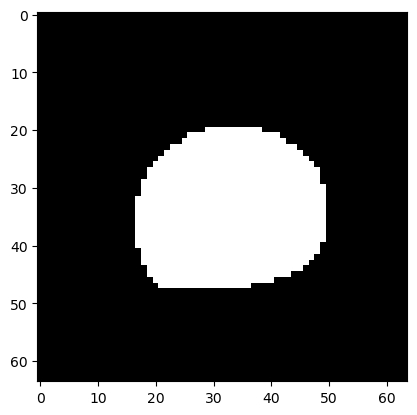

Label: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
img: tensor([[-1.0192e+00, -6.7089e-01, -1.0117e+00,  ...,  4.1301e-01,
          7.2984e-01,  6.8562e-01],
        [-9.8880e-01, -7.5767e-01, -1.0756e+00,  ...,  3.3681e-01,
          5.5584e-01,  6.7040e-01],
        [-1.1918e+00, -1.0600e+00, -9.6114e-01,  ...,  3.1343e-01,
          3.3303e-01,  2.1588e-01],
        ...,
        [-1.1705e-01, -6.6495e-01, -5.5873e-01,  ..., -4.0082e-01,
         -9.5008e-01, -1.0130e+00],
        [-5.0188e-04, -3.9662e-01, -4.5517e-01,  ..., -7.9720e-01,
         -1.0065e+00, -1.0424e+00],
        [ 2.0695e-01,  2.8541e-02, -2.4718e-02,  ...,  8.0467e-04,
         -8.2472e-01, -1.4294e-01]])


In [7]:
import matplotlib.pyplot as plt
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


img = train_features[0].squeeze()
label = train_labels[0].squeeze()

#plt.imshow(img, cmap="gray")
plt.imshow(label,cmap='gray',)
plt.show()
print(f"Label: {label}")
print(f"img: {img}")


torch.Size([32, 1, 64, 64])
torch.Size([16, 16])


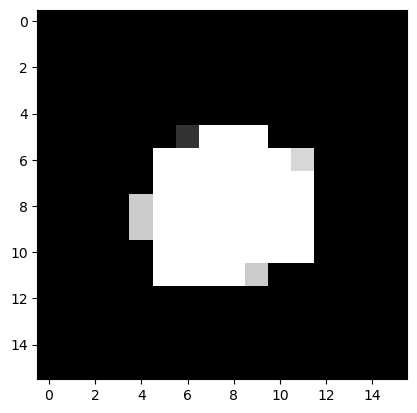

In [8]:
down=torch.nn.UpsamplingBilinear2d(scale_factor=1/4)
print(train_labels.size())
train_labels=down(train_labels.type(torch.float32))
label = train_labels[0].squeeze()
plt.imshow(label,cmap='gray')
print(label.size())

torch.Size([1, 16, 16])
torch.Size([16, 16])


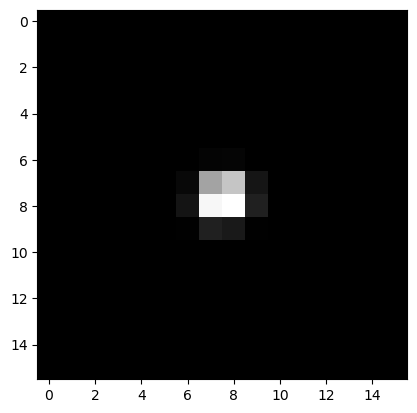

In [9]:
import torchvision.transforms as transforms


img_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.CenterCrop(64),
        transforms.Resize([16,16]),
        transforms.ToTensor(),
    ]
)



labeld=img_transform(train_labels[0])
print(labeld.size(
))
label = labeld[0].squeeze()
print(label.size())
plt.imshow(label,cmap='gray')

In [10]:
# load validation data
valid_dataset = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

In [11]:
import VAE_GAN


In [12]:

lr_gen = 0.0002
lr_dis=0.00005
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True

vae=VAE_GAN.VAE()
dis=VAE_GAN.Discriminator()


noise = torch.randn(32, 255)
noise = noise.to(device)
#criterion=GANLoss()


opt_gen = torch.optim.Adam(vae.generator.parameters(), lr=LEARNING_RATE)
opt_enc=torch.optim.Adam(vae.encoder.parameters(), lr=LEARNING_RATE)
#opt_gen= torch.optim.Adam(gen.parameters(), lr=lr_gen)
opt_dis= torch.optim.Adam(dis.parameters(), lr=lr_dis)

TENSORBOARD_LOGDIR='vae_gan'

In [13]:
def saveModels():
    torch.save(vae.generator.state_dict(), CHECKPOINTS_DIR / "vae_enc.pth")
    torch.save(dis.state_dict(), CHECKPOINTS_DIR / "vae_dis.pth")
    torch.save(vae.encoder.state_dict(), CHECKPOINTS_DIR / "vae_gen.pth")


scheduler = torch.optim.lr_scheduler.LambdaLR(opt_enc, lr_lambda)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt_gen, lr_lambda)

In [14]:
# https://notebook.community/zklgame/CatEyeNets/test/GANs-PyTorch
#https://www.researchgate.net/figure/Figure-S36-The-label-input-method-for-the-generator-in-CcGAN_fig5_348834209
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Variable of shape (N, ) giving scores.
    - target: PyTorch Variable of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Variable containing the mean BCE loss over the minibatch of input data.
    """
    #neg_abs = - input.abs()
    #loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    BCE=torch.nn.BCELoss()
    loss=BCE(input,target)
    return loss

In [15]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    real_loss = bce_loss(logits_real, torch.ones(BATCH_SIZE,1))
    fake_loss = bce_loss(logits_fake, torch.zeros(BATCH_SIZE,1))
    loss = (real_loss + fake_loss) #Have a look at this ? correct?
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    loss = bce_loss(logits_fake, torch.ones(BATCH_SIZE,1))
    return loss

In [17]:
img_lists = []
G_losses = []
D_losses = []
iters = 0
from torch.autograd import Variable

writer = SummaryWriter(log_dir=TENSORBOARD_LOGDIR)  # tensorboard summary



for epoch in tqdm(range(N_EPOCHS)):
    print(f'Epoch {epoch+1}/{N_EPOCHS}')
    for (img, seg) in tqdm(dataloader):
        img = img.to(device)
        seg = seg.to(device)

        seg=seg.float()

        
        fake_img, mu, logvar  = vae(img,seg) #remove seg if you want to train without labels
        
        pred_fake = dis(fake_img,seg) 
        

        # Real Detection and Loss
       
        pred_real = dis(img,seg)
    
        
        
        
        loss_enc = VAE_GAN.vae_loss(img, fake_img, mu, logvar)
        loss_G =  generator_loss(pred_fake)+loss_enc


        opt_enc.zero_grad()

        loss_enc.backward(retain_graph=True)

        opt_enc.step()
    
        
        opt_gen.zero_grad()
        
        loss_G.backward(retain_graph=True)
        
        opt_gen.step()

        G_losses.append(loss_G.detach().cpu())


        dis.trainable=True
       

        loss = discriminator_loss(pred_real,pred_fake)
        #loss_fake=adversarial_loss(pred_fake,seg)        
        loss_D=loss
        
        
        opt_dis.zero_grad()
        loss_D.backward()
        opt_dis.step()
        
        
        D_losses.append(loss_D.detach().cpu())
        
        dis.trainable = False
        

        
        # if i%200 == 0:
        #     print("Iteration {}/{} started".format(i+1, len(dataloader)))
    writer.add_scalar("Loss dis", loss_D / len(dataloader), epoch)
    writer.add_scalar("Loss gen", loss_G / len(dataloader), epoch)  
    scheduler.step()   
    print("G_loss= ",loss_G, " : D_Loss= ", loss_D)

    
    if (epoch + 1) % 1 == 0: #This is for the tensorboard
        vae.generator().eval()
        img_grid = make_grid(
            torch.cat((fake_img[:5], img[:5])), nrow=5, padding=12, pad_value=-1
        )
        writer.add_image(
            "Real/fake_recon",
            np.clip(img_grid[0][np.newaxis], -1, 1) / 2 + 0.5,
            epoch + 1,
        )
        
    if epoch%2 == 0:
        with torch.no_grad():
            img_lists.append(fake_img.detach().cpu().numpy())
    #Plot results between epochs to see if it generates something
    if epoch%2==0:
        for (num,_) in enumerate(img_grid):
            print(num)
            img = img_grid[num].squeeze()
            #label = train_labels[num].squeeze()
            plt.imshow(img, cmap="gray")
            #plt.imshow(label,cmap='gray',alpha=0.3)
            plt.show()
    saveModels()
                
    iters+=1


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


c:\Users\20181758\Anaconda3\envs\8DM20\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Error detected in SigmoidBackward0. No forward pass information available. Enable detect anomaly during forward pass for more information. (Triggered internally at  C:\b\abs_f0dma8qm3d\croot\pytorch_1669187301762\work\torch\csrc\autograd\python_anomaly_mode.cpp:85.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 0/10 [00:22<?, ?it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
#Load tensorboard
%load_ext tensorboard
%tensorboard --logdir='GAN_runs'

100%|██████████| 37/37 [09:21<00:00, 15.18s/it]


train loss=  tensor(0.7469, grad_fn=<AddBackward0>)


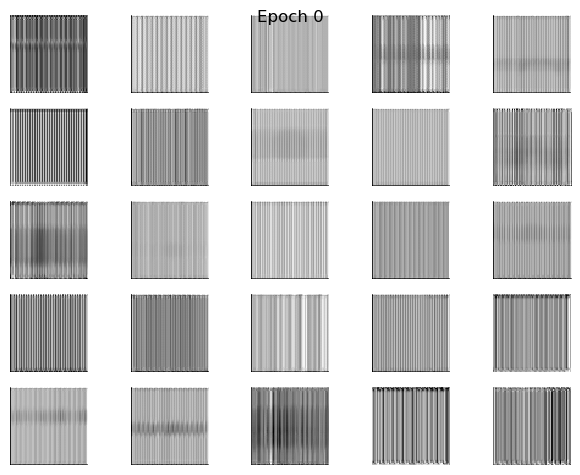

100%|██████████| 37/37 [09:30<00:00, 15.42s/it]


train loss=  tensor(0.8496, grad_fn=<AddBackward0>)


100%|██████████| 37/37 [09:03<00:00, 14.69s/it]


train loss=  tensor(0.9005, grad_fn=<AddBackward0>)


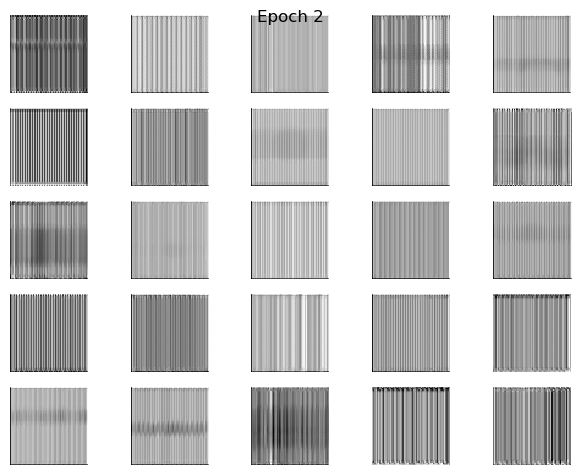

100%|██████████| 37/37 [08:56<00:00, 14.51s/it]


train loss=  tensor(0.9833, grad_fn=<AddBackward0>)


100%|██████████| 37/37 [08:57<00:00, 14.52s/it]


train loss=  tensor(1.0136, grad_fn=<AddBackward0>)


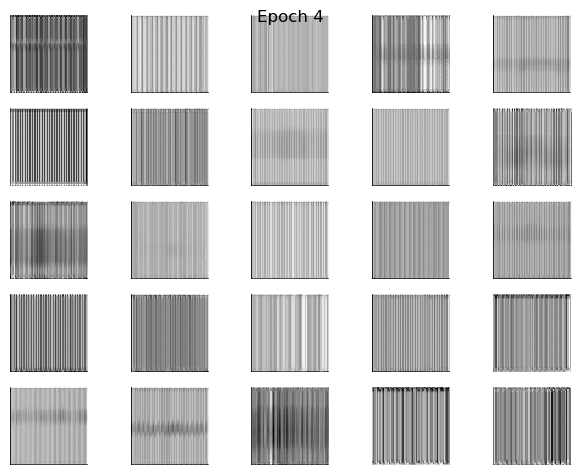

100%|██████████| 37/37 [08:55<00:00, 14.48s/it]


train loss=  tensor(1.0363, grad_fn=<AddBackward0>)


100%|██████████| 37/37 [08:54<00:00, 14.45s/it]


train loss=  tensor(1.1067, grad_fn=<AddBackward0>)


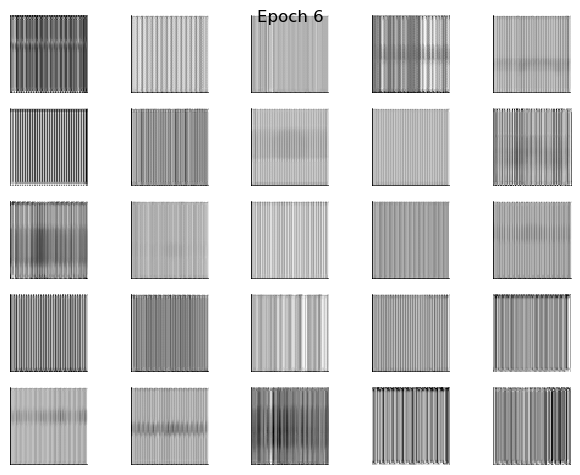

100%|██████████| 37/37 [08:52<00:00, 14.40s/it]


train loss=  tensor(1.1261, grad_fn=<AddBackward0>)


100%|██████████| 37/37 [08:52<00:00, 14.40s/it]


train loss=  tensor(1.1998, grad_fn=<AddBackward0>)


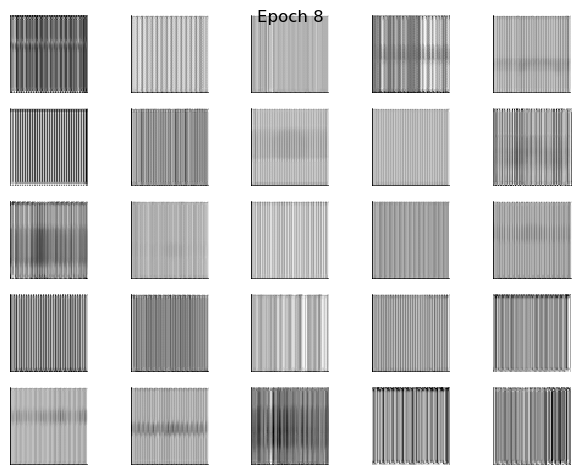

100%|██████████| 37/37 [08:51<00:00, 14.38s/it]


train loss=  tensor(1.3036, grad_fn=<AddBackward0>)


In [ ]:
# # training loop
# writer = SummaryWriter(log_dir=TENSORBOARD_LOGDIR)  # tensorboard summary
# loss_train=[]
# img_list_vae=[]
# for epoch in range(N_EPOCHS):
#     current_train_loss = 0.0
#     current_valid_loss = 0.0

#     for x_real, mask in tqdm(dataloader,position=0):
#         # needed to zero gradients in each iteration
#         optimizer.zero_grad()
#         x_recon, mu, logvar = vae_model(x_real,mask)  # forward pass
#         loss = vae.vae_loss(x_real, x_recon, mu, logvar)
#         loss_train.append(loss)
#         current_train_loss += loss.item()
#         loss.backward()  # backpropagate loss
#         optimizer.step()  # update weights

#     # write to tensorboard log
#     print("train loss= ", loss_train[epoch])
#     writer.add_scalar("Loss/train", loss_train[epoch], epoch)

#     scheduler.step()  # step the learning step scheduler

#     #save examples of real/fake images
#     if (epoch + 1) % 1 == 0:
#         vae_model.eval()
#         img_grid = make_grid(
#             torch.cat((x_recon[:5], x_real[:5])), nrow=5, padding=12, pad_value=-1
#         )
#         writer.add_image(
#             "Real/fake_recon",
#             np.clip(img_grid[0][np.newaxis], -1, 1) / 2 + 0.5,
#             epoch + 1,
#         )

#         noise = torch.randn(32, Z_DIM)
#         image_samples = vae_model.generator(noise,mask)
#         img_grid = make_grid(
#             torch.cat((image_samples[:5], image_samples[5:])),
#             nrow=5,
#             padding=12,
#             pad_value=-1,
#         )
#         writer.add_image(
#             "Samples",
#             np.clip(img_grid[0][np.newaxis], -1, 1) / 2 + 0.5,
#             epoch + 1,
#         )
#     if epoch%2 == 0:
#         with torch.no_grad():
#             img_list_vae.append(image_samples.detach().cpu().numpy())
#     #Plot results between epochs to see if it generates something
#     if epoch%2==0:
#         for i in range(25):
#             plt.subplot(5, 5, i+1)
#             img=img_list_vae[0].squeeze()
#             #print(img.shape)
#             plt.imshow(img[i], interpolation='nearest', cmap='gray_r')
#             plt.axis('off')
#         plt.tight_layout()
#         plt.suptitle('Epoch {}'.format(epoch))
#         plt.show()
#         saveModels(epoch)

#     vae_model.train()


# torch.save(vae_model.state_dict(), CHECKPOINTS_DIR / "vae_model.pth")

In [ ]:

%load_ext tensorboard
%tensorboard --logdir='vae_sp'

In [ ]:
import torchvision.transforms as transforms
img_size=[8,8]
mr_image_list=[]


img_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.CenterCrop(64),
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ]
)
# standardise intensities based on mean and std deviation
train_data_mean = np.mean(mr_image_list)
train_data_std = np.std(mr_image_list)
norm_transform = transforms.Normalize(
    train_data_mean, train_data_std
)

c:\Users\20181758\Anaconda3\envs\8DM20\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\20181758\Anaconda3\envs\8DM20\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\20181758\Anaconda3\envs\8DM20\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\20181758\Anaconda3\envs\8DM20\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\20181758\Anaconda3\envs\8DM20\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
